# Census
Natalia Vélez, September 2020

In this notebook:
* How much activity was there in each server? in each release?
* Aggregate measures: Age and cause of death
* How stable are these aggregate measures over different releases?

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

sns.set_style('white')
sns.set_context('talk')

## Prepare data for analysis

Load all data:

In [2]:
eras = ['arc', 'rift', 'boundless']
era_data = []
for e in eras:
    era_file = 'outputs/lifelogs_bigserver2_%s_data.tsv' % e
    era_data.append(pd.read_csv(era_file, sep='\t', index_col=0))

# All bigserver2 data
big_df = pd.concat(era_data)
big_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,server,release,era,event,timestamp,avatar,player,age,sex,location,parent,cause_of_death,killer
0,bigserver2,194.0,arc,B,1548804597,2.0,a51edcb77a3900d53adc61d394876c5ca7417486,NaN,F,"(50, -7)",NaN,NaN,NaN
1,bigserver2,194.0,arc,D,1548807206,2.0,a51edcb77a3900d53adc61d394876c5ca7417486,57.49,F,"(64, -8)",NaN,hunger,NaN
2,bigserver2,194.0,arc,B,1548814222,3.0,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,NaN,F,"(1453, -436)",NaN,NaN,NaN
3,bigserver2,194.0,arc,B,1548814226,4.0,0c1781b6944db9e58b5d71adfe64af09fedad796,NaN,M,"(1453, -436)",3.0,NaN,NaN
4,bigserver2,194.0,arc,B,1548814227,5.0,77a67da50b453a570d1e3311a56cd9da89187cd2,NaN,F,"(1366, -395)",NaN,NaN,NaN


## How many players/lives are in the dataset?

### Birth/death events

Births/deaths by release:

In [3]:
big_activity = big_df.groupby(['release', 'event']).agg({'avatar': 'count'})
big_activity = big_activity.reset_index()

big_activity.head()

,release,event,avatar
0,194.0,B,24802
1,194.0,D,24648
2,196.0,B,76648
3,196.0,D,76591
4,197.0,B,39672


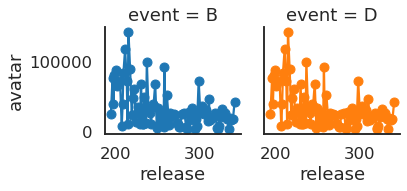

In [4]:
grid = sns.FacetGrid(big_activity, col="event", hue="event")
grid.map(plt.plot, "release", "avatar", marker="o")

Total births and deaths:

In [5]:
big_activity.groupby('event')['avatar'].sum()

event
B    2934434
D    2929785
Name: avatar, dtype: int64

Overall, there are fewer deaths in the data than there are births. Is this because the data for the last release before we initiated the download was incomplete, or because the data are consistently cut off at each release? 


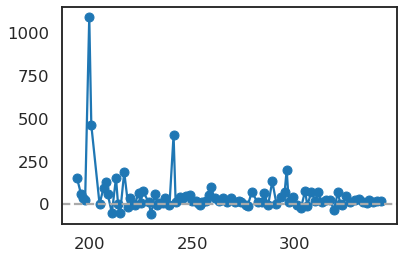

In [6]:
big_by_release = big_activity.groupby(['release', 'event'])['avatar'].sum().reset_index()
big_diff = big_by_release.pivot(index='release', columns='event', values='avatar').reset_index()
big_diff['diff'] = big_diff['B'] - big_diff['D']

plt.plot(big_diff['release'], big_diff['diff'], marker = 'o')
plt.axhline(y = 0, linestyle = '--', color='#aaaaaa')

## Charting individual players' expertise

Each player has a unique, anonymized hash associated with them. By tracking how often a particular hash appears in birth events, we can get a sense of how many "lives" unique players contribute to the dataset. I am also particularly curious about whether there might be some particularly prolific "power-users" driving innovation and development.

Filter birth events:

In [7]:
big_births = big_df[big_df['event'] == 'B'].reset_index(drop=True)
big_births.head()

,server,release,era,event,timestamp,avatar,player,age,sex,location,parent,cause_of_death,killer
0,bigserver2,194.0,arc,B,1548804597,2.0,a51edcb77a3900d53adc61d394876c5ca7417486,NaN,F,"(50, -7)",NaN,NaN,NaN
1,bigserver2,194.0,arc,B,1548814222,3.0,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,NaN,F,"(1453, -436)",NaN,NaN,NaN
2,bigserver2,194.0,arc,B,1548814226,4.0,0c1781b6944db9e58b5d71adfe64af09fedad796,NaN,M,"(1453, -436)",3.0,NaN,NaN
3,bigserver2,194.0,arc,B,1548814227,5.0,77a67da50b453a570d1e3311a56cd9da89187cd2,NaN,F,"(1366, -395)",NaN,NaN,NaN
4,bigserver2,194.0,arc,B,1548814231,6.0,ae87cea72e02d701fbb807b56113e3f7a3d20b83,NaN,M,"(1366, -395)",5.0,NaN,NaN


### Total occurrences

Count occurrences of each player:

In [8]:
big_player = big_births.groupby('player')['timestamp'].count().reset_index()
big_player = big_player.rename(columns={"timestamp": "n_lives"})
big_player.head()

,player,n_lives
0,00006debdd4d630a4a5aa395135a70a69e0db01e,3
1,0001394319e5e63bb74219fef647e9ff24507a21,4
2,0002e5ea5ce7cfd761135d255a245a3344af4377,338
3,00030d8a6d24ff9a416642f51ef68408cd846ec8,3
4,00047b60a01d908e2407b05a09b404c2f6cec6f6,4


How many unique players are there?

In [9]:
big_player.shape[0]

45209

How many lives does each player contribute?

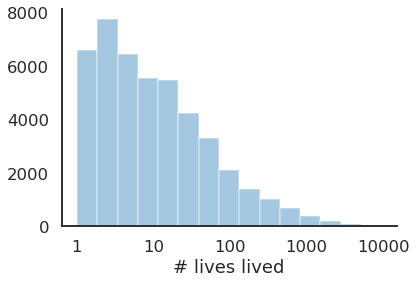

In [10]:
n_lives = np.log10(big_player['n_lives'].values)
x_life = np.arange(0,5)
x_life_labels = [10**x for x in x_life]
g = sns.distplot(n_lives, bins=15, kde=False)
g.set(xticks=x_life, xticklabels=x_life_labels, xlabel = '# lives lived')
sns.despine()

Some descriptive statistics:

In [11]:
print('Max: %f' % 10**np.max(n_lives))
print('Min: %f' % 10**np.min(n_lives))
print('Median: %f' % 10**np.median(n_lives))
print(stats.mode(n_lives))

Max: 9477.000000
Min: 1.000000
Median: 8.000000
ModeResult(mode=array([0.]), count=array([6589]))


Empirical CDF:

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


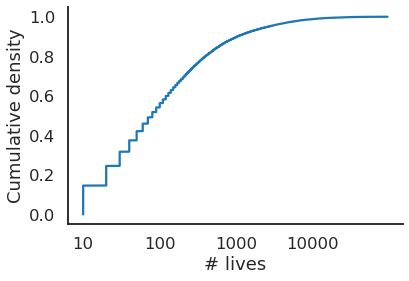

In [12]:
n_lives_ecdf = ECDF(n_lives)
fig, ax = plt.subplots()
ax.plot(n_lives_ecdf.x, n_lives_ecdf.y)
ax.set_xlabel('# lives')
ax.set_ylabel('Cumulative density')
ax.set_xticklabels(x_life_labels)
sns.despine()

Cumulative counts:

In [13]:
lives_breaks_labels = [1, 10, 25, 50, 100, 500, 1000, 2500, 4000]
lives_breaks = np.log10(lives_breaks_labels)
lives_prop = n_lives_ecdf(lives_breaks)

lives_list = list(zip(lives_breaks_labels, lives_prop))
print(*['p <= %i: %0.3f' % (l[0], l[1]) for l in lives_list], sep='\n')

p <= 1: 0.146
p <= 10: 0.563
p <= 25: 0.732
p <= 50: 0.831
p <= 100: 0.897
p <= 500: 0.973
p <= 1000: 0.988
p <= 2500: 0.997
p <= 4000: 0.999


Top contributors:

In [14]:
big_top = big_player.sort_values('n_lives', ascending=False).reset_index(drop=True)
big_top.to_csv('outputs/topplayers_all.tsv', sep='\t', index=True)
big_top[:100]

,player,n_lives
0,8ac173f9346f99eff5fb54d55b57acaace951896,9477
1,71f0317c349c25ec4188f1b501d05bd99d54b505,8766
2,3ce403481bf68baf1b158a2bf7f12ed93c0a47fe,8399
3,2260ec3961330cf12ed97ad87a93d52fa1f335fa,7446
4,ea5ea8d1bef19a9847bc8ca874e2dfa0a847ffc9,7343
...,...,...
95,f4fbfe827a1085f50ee410dab31c4d441ea29a76,2877
96,dca75e529655db4735c8859531966064b39c0181,2877
97,0770efcd0bb4135118ffd513e347a9b2dcea0148,2864
98,83c198916cbe5c71ad384bb833265c027fc70735,2855


## When and how do people die?

Filter deaths:

In [15]:
death_data = big_df[big_df['event'] == 'D'].reset_index(drop=True)
death_data.head()

,server,release,era,event,timestamp,avatar,player,age,sex,location,parent,cause_of_death,killer
0,bigserver2,194.0,arc,D,1548807206,2.0,a51edcb77a3900d53adc61d394876c5ca7417486,57.49,F,"(64, -8)",NaN,hunger,NaN
1,bigserver2,194.0,arc,D,1548814282,8.0,b3a2c99deced24ac11f6b8b10ba49066ca96606d,0.48,M,"(1387, -433)",NaN,hunger,NaN
2,bigserver2,194.0,arc,D,1548814301,16.0,c5c94e5501424d0567c90730f5e2e6ad482a440f,0.09,M,"(1452, -419)",NaN,disconnect,NaN
3,bigserver2,194.0,arc,D,1548814310,18.0,c5c94e5501424d0567c90730f5e2e6ad482a440f,0.09,F,"(1414, -462)",NaN,disconnect,NaN
4,bigserver2,194.0,arc,D,1548814313,14.0,b3a2c99deced24ac11f6b8b10ba49066ca96606d,0.45,M,"(1431, -428)",NaN,hunger,NaN


Plotting 2929785 deaths


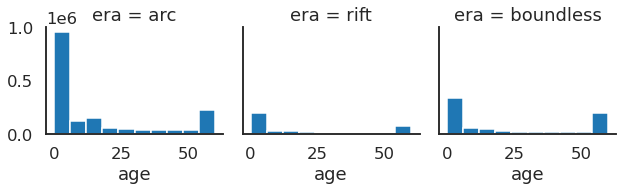

In [16]:
print('Plotting %i deaths' % len(death_data))
g = sns.FacetGrid(death_data, col="era")
g.map(plt.hist, "age", )

Frequency of causes of death:

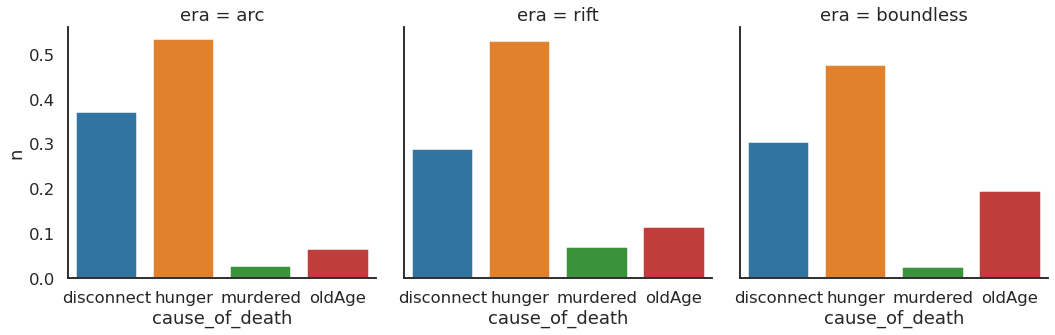

In [17]:
cause_summ = death_data.groupby(['era', 'cause_of_death'])['age'].agg('count').reset_index()
cause_summ = cause_summ.rename(columns={'age': 'n'})
cause_summ['n'] = cause_summ['n']/cause_summ.groupby('era')['n'].transform('sum')
cause_summ['era'] = pd.Categorical(cause_summ['era'], categories = ['arc', 'rift', 'boundless'])

sns.catplot(data=cause_summ, x='cause_of_death', y='n', col='era', kind='bar')

Age by cause of death (excluding old age):

In [18]:
?sns.FacetGrid

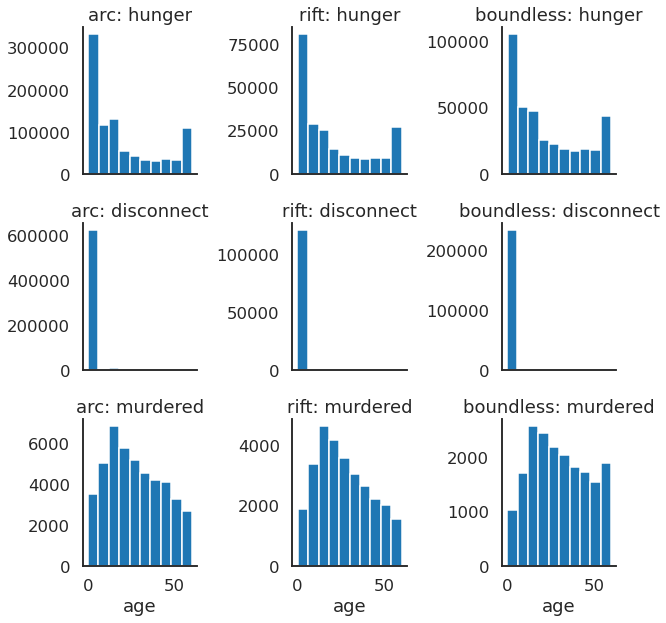

In [19]:
nonold_death = death_data[~death_data['cause_of_death'].str.contains('oldAge')]

g = sns.FacetGrid(nonold_death, row='cause_of_death', col='era', sharey=False)
g.map(plt.hist, "age")
g.set_titles('{col_name}: {row_name}')

Save IDs from players who disconnected in infancy. (We will exclude them from some analyses, since they do not contribute to their communities.)

In [20]:
infant_df = death_data[(death_data['cause_of_death'] == 'disconnect') & (death_data['age'] <= 2)]
infant_df = infant_df.reset_index(drop=True)
infant_deaths = infant_df.avatar.values.astype(np.int)

n_all_deaths = len(death_data)
n_infants = len(infant_deaths)

print('Found %i avatars who disconnected as babies (%0.2f%% of total)' % (n_infants, n_infants/n_all_deaths*100))
print(infant_deaths[-10:])

np.savetxt('outputs/infant_deaths.txt', infant_deaths, fmt='%i')

Found 981597 avatars who disconnected as babies (33.50% of total)
[3080238 3080239 3080240 3080241 3080244 3080246 3080247 3080250 3080248
 3080253]


## Cumulative expertise x survival

In [21]:
expert_df = death_data.copy()
expert_df = expert_df[['era', 'timestamp', 'avatar', 'player', 'age']]
expert_df = expert_df.sort_values(['player', 'timestamp']).reset_index(drop=True)
expert_df['n_life'] = expert_df.groupby('player').cumcount()
expert_df['gametime'] = expert_df.groupby('player')['age'].cumsum()
expert_df['gametime'] = expert_df.groupby('player')['gametime'].shift(periods=1, fill_value=0)
expert_df.head()

,era,timestamp,avatar,player,age,n_life,gametime
0,arc,1552917464,630641.0,00006debdd4d630a4a5aa395135a70a69e0db01e,13.88,0,0.00
1,arc,1552917768,630737.0,00006debdd4d630a4a5aa395135a70a69e0db01e,4.98,1,13.88
2,arc,1552918072,630799.0,00006debdd4d630a4a5aa395135a70a69e0db01e,4.68,2,18.86
3,arc,1550134390,214206.0,0001394319e5e63bb74219fef647e9ff24507a21,33.78,0,0.00
4,arc,1550135155,214530.0,0001394319e5e63bb74219fef647e9ff24507a21,7.25,1,33.78


Save to file:

In [22]:
expert_df.to_csv('outputs/player_expertise.tsv', sep='\t', index=None)